# Anomaly Detection with Multivariate Distribution 

#### Summary
This notebook is the POC of a side project at work where I need to create a flexible model to identify data anomalies of global security markets.

#### Methodology
The core method is very simple:
- build a multivariate distribution from historical data.
- Check how likely an event happens based on the distribution.

#### Disclaimer
Data used in this notebook is somewhat fake - scaled with noise added but retaining the relative changes of the real data

# Part I. The Model

In [308]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal, norm

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data

- order_new: order sent to HKEX by this market participant
- order_update: order updated by this market participant
- order_delete: order deleted by this market participant
- transaction: transaction on HKEX of all market participant
- transaction_cancel: transaction cancelled by this market participant
- market_quote: order changes by all market participant
- stock_status_update: message that tells when a particular stock starts/ends trading, etc.
##### Note: HKEX public data is privately owned - data used in here is scaled with random noise added while maintaining the relative changes of the real data

In [345]:
# Import data
csv = 'data/hkex.csv'
raw_msg_count = pd.read_csv(csv)

# Use 'date' as index
raw_msg_count.date = pd.to_datetime(raw_msg_count.date, format='%Y%m%d')
raw_msg_count = raw_msg_count.set_index(['date'])

# Exclude Rows with all values == 0
raw_msg_count = raw_msg_count[raw_msg_count.sum(axis=1) != 0]

# Take a look
raw_msg_count.head(5)

,order_update,transaction_cancel,stock_status_update,order_delete,order_new,market_quote,transaction
date,,,,,,,
2016-01-04,17752.0,0,25774.0,18617.0,23144.0,6690586.5,578599.5
2016-01-05,11629.5,0,25347.0,20608.5,22820.0,6794326.5,600195.0
2016-01-06,6871.0,0,25235.0,16222.5,20882.0,6075386.5,597437.0
2016-01-07,9028.5,0,25130.0,17119.5,21980.0,8351378.0,833078.5
2016-01-08,22167.5,0,24626.0,31650.5,35048.0,7262904.0,652075.5


### Feature Selection and Manipulation
##### Note: Where domain knowledge can be injected. 

In [310]:
# Exclude noisy & useless metrics
exclude_features = ['transaction_cancel']  # Excluse 'transaction_cancelled' here as it is sort of a random thing

# What's left will be feed into the model
included_features = [feature for feature in list(pd.unique(raw_msg_count.columns)) if feature not in exclude_features]

##############################################################################################################
### FOR THE FUTURE: new metrics can be derived from the collected metrics - to increase model performance
##############################################################################################################

msg_count = raw_msg_count[included_features]

# Take a look
msg_count.head()

,order_update,stock_status_update,order_delete,order_new,market_quote,transaction
date,,,,,,
2016-01-04,17752.0,25774.0,18617.0,23144.0,6690586.5,578599.5
2016-01-05,11629.5,25347.0,20608.5,22820.0,6794326.5,600195.0
2016-01-06,6871.0,25235.0,16222.5,20882.0,6075386.5,597437.0
2016-01-07,9028.5,25130.0,17119.5,21980.0,8351378.0,833078.5
2016-01-08,22167.5,24626.0,31650.5,35048.0,7262904.0,652075.5


### Model Parameters

#### Key Model Parameters
- **rolling_window**: The number days of historical data used to build the distribution
- **epsilon**: Probability threshold, probability lower than epsilon will be considered outlier

#### Additional Parameters
- **weight**: Skewing the importance of the features - where domain knowledge can be injected
- **penalize_zero_feature**: features to apply zero penalty (*not implemented here*)
- **penalize_zero_factor**: by how much we penalize zeros (*not implemented here*)

*Note: penalize zero is used for features that are normally very small but should not be zero - in which case the model won't consider it an outlier*

In [311]:
rolling_window = 60    
epsilon = 1e-50    

# Use weight to control feature importance
# We can use different starting weight here - [0,1) - scale down, (1,infinity] - scale up. 
weight = pd.DataFrame([msg_count.shape[1] * [1.0],], columns=msg_count.columns, index=['weight'])

# Update weight
# e.g.
# weight['order_amend'] = 0.8

# Take a look
weight

,order_update,stock_status_update,order_delete,order_new,market_quote,transaction
weight,1.0,1.0,1.0,1.0,1.0,1.0


### Feature Standardization (z-score)

Standardizing feature so model won't be skewed towards features with larger values - and bringing the distribution closer to standard normal distribution

In [312]:
### Manual Standardization
# Shifting mean and std because when accessing mean and std for 'date', we want to use mean and std calculated from 'date - rolling_window - 1' to 'date - 1'
rolling_mean = msg_count.rolling(window=rolling_window).mean().shift(1)
rolling_std = msg_count.rolling(window=rolling_window).std().shift(1)

# Standardization
msg_count_scaled = (msg_count - rolling_mean) / rolling_std

### Use the first rolling mean & std to standardize the first 'rolling_window' number of records 
msg_count_scaled.iloc[0:rolling_window] = (msg_count.iloc[0:rolling_window] - rolling_mean.iloc[rolling_window]) / rolling_std.iloc[rolling_window]

# ## Standardization with sklearn
# sc = StandardScaler()
# msg_count_scaled = pd.DataFrame(sc.fit_transform(msg_count), 
#                                     index=msg_count.index,
#                                     columns=msg_count.columns)
# ##############################################################

# Take a look at scaled data
msg_count_scaled.head()

,order_update,stock_status_update,order_delete,order_new,market_quote,transaction
date,,,,,,
2016-01-04,-0.753137,1.171172,-0.450437,-0.513724,0.663387,-0.276320
2016-01-05,-1.328341,0.252310,-0.142765,-0.563815,0.789944,0.026203
2016-01-06,-1.775399,0.011297,-0.820369,-0.863433,-0.087124,-0.012433
2016-01-07,-1.572704,-0.214652,-0.681789,-0.693680,2.689462,3.288583
2016-01-08,-0.338304,-1.299210,1.563140,1.326656,1.361583,0.752978


#### Before and after feature standardization

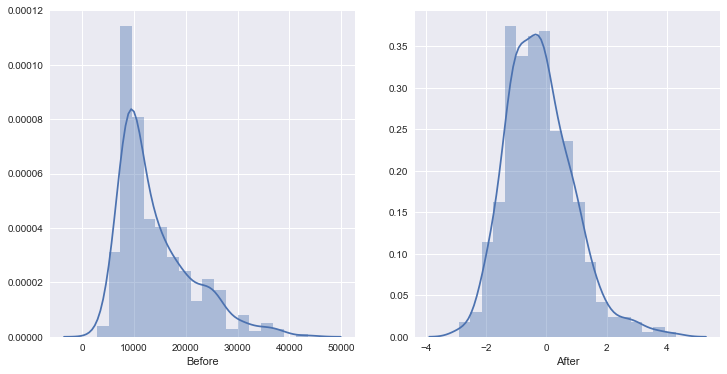

In [340]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sns.distplot(msg_count.order_new, ax=axs[0], axlabel='Before')
sns.distplot(msg_count_scaled.order_new, ax=axs[1], axlabel='After');

#### Check feature relations

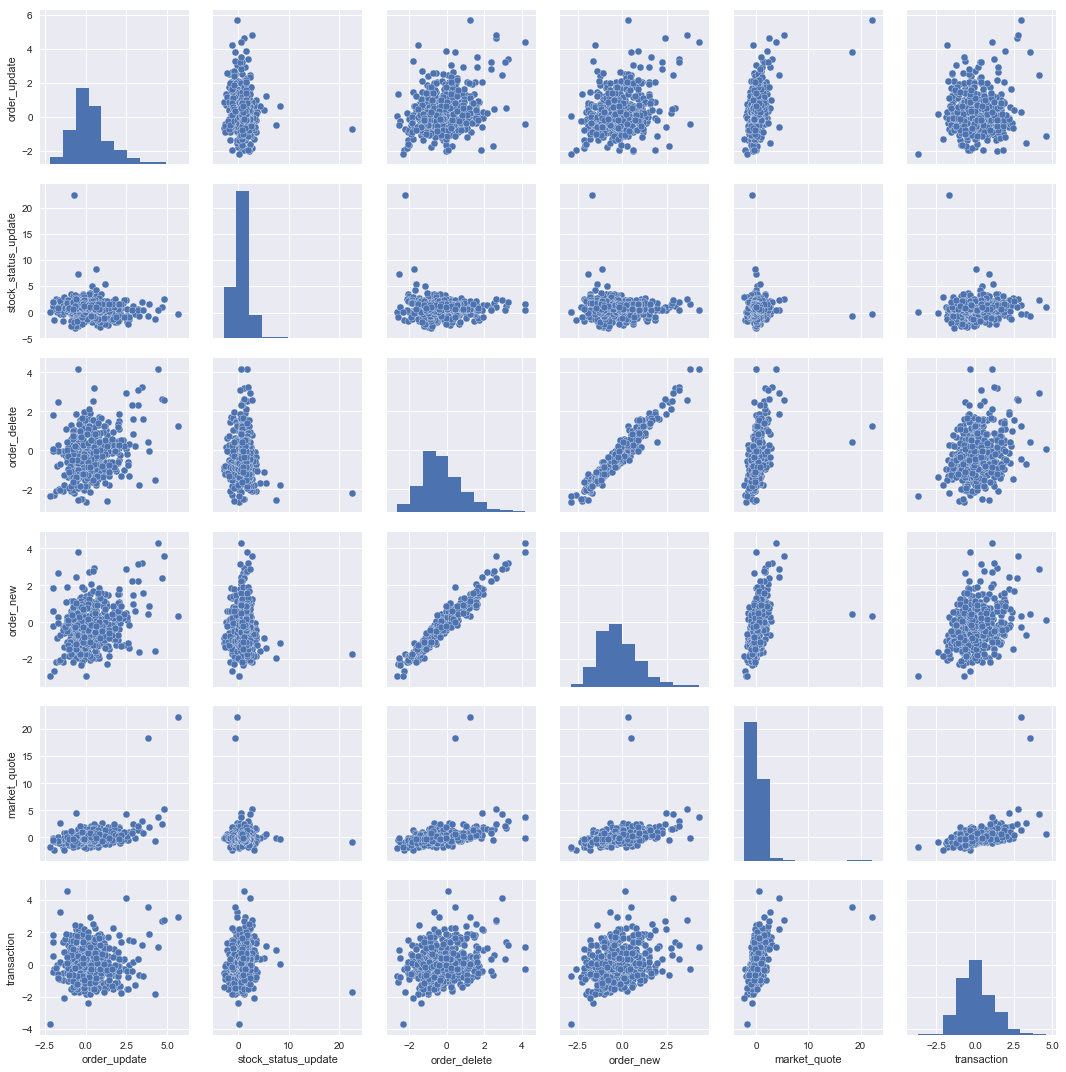

In [344]:
sns.pairplot(msg_count_scaled);

### Recalc Rolling Mean and Calc Rolling Covariance Matrix

- Rolling mean and std calculated earlier are for standardizing the data
- Rolling mean and covariance matrix here are calculated from standardized data for building multivariate distribution

In [298]:
rolling_mean_scaled = msg_count_scaled.rolling(window=rolling_window).mean().shift(1)
rolling_cov_scaled = msg_count_scaled.rolling(window=rolling_window).cov().shift(msg_count_scaled.shape[1])
rolling_cov_scaled.index.names =['date', 'msg']

# Take a look
rolling_cov_scaled.tail(6)

order_update  stock_status_update  \
date       msg                                                      
2017-10-12 order_update             1.583787             0.103616   
           stock_status_update      0.103616             0.285891   
           order_delete             0.477332             0.099580   
           order_new                0.463475             0.195625   
           market_quote             1.031689             0.088737   
           transaction              0.410739             0.028837   

                                order_delete  order_new  market_quote  \
date       msg                                                          
2017-10-12 order_update             0.477332   0.463475      1.031689   
           stock_status_update      0.099580   0.195625      0.088737   
           order_delete             0.750071   0.758044      0.624427   
           order_new                0.758044   0.938828      0.638627   
           market_quote             0.624427   0.638627      1.286548   
           transaction              0.364576   0.402204      0.738074   

                                transaction  
date       msg                               
2017-10-12 order_update            0.410739  
           stock_status_update     0.028837  
           order_delete            0.364576  
           order_new               0.402204  
           market_quote            0.738074  
           transaction             1.077317

### Calculate Probabilities

In [349]:
# Init a container for probabilities
probabilities = pd.DataFrame(msg_count_scaled.shape[0] * [np.NaN], columns=['probability'])
probabilities.index = msg_count_scaled.index

for date in rolling_mean_scaled.index[rolling_window+1:]:
    event_probability = multivariate_normal.pdf(msg_count_scaled.loc[date] * weight, mean=rolling_mean_scaled.loc[date], cov=rolling_cov_scaled.loc[date])
    # print('date %s, prob %s' % (date, event_probability))
    probabilities['probability'][date] = event_probability

# Take a look
np.min(probabilities)

probability    6.353079e-233
dtype: float64

### Find outliers based on probability calculated

In [301]:
# Find outliner
outliers = msg_count[probabilities['probability'] < epsilon]
outliers

,order_update,stock_status_update,order_delete,order_new,market_quote,transaction
date,,,,,,
2016-06-24,118174.5,25011.0,19536.5,21750.5,17555909.0,713664.5
2016-07-25,44204.0,32355.0,5543.0,9851.0,4457408.5,400056.5
2016-11-09,115002.5,39622.5,12732.0,16452.0,21955651.5,784721.0


# Part II. Further analysis  

### Look into individual features

The table below gives us a quick understanding of what metrics contributes to the indicent
- e.g. On 2016-06-24 and 2016-11-09 market_quote is the main reason of them being considered outliers

In [302]:
outlier_rolling_mean = rolling_mean.loc[outliers.index]
outlier_rolling_std = rolling_std.loc[outliers.index]
outlier_metric_probability = pd.DataFrame(norm.pdf(outliers.values * weight.values, loc=outlier_rolling_mean, scale=outlier_rolling_std),
                                          index=outliers.index,
                                          columns=outliers.columns)

outliers_for_display = outliers.copy()

outliers_for_display['Event Probability (epsilon=%s)' % epsilon] = probabilities[probabilities['probability'] < epsilon]['probability']

outliers_for_display['type'] = 'Msg Count'
outlier_rolling_mean['type'] = str(rolling_window) + ' Days Rolling Mean'
outlier_rolling_std['type'] = str(rolling_window) + ' Days Rolling Std'
outlier_metric_probability['type'] = str(rolling_window) + ' Days Univariate Probability'

outliers_for_display = outliers_for_display.append(outlier_rolling_mean).append(outlier_rolling_std).append(outlier_metric_probability)
outliers_for_display.set_index('type', append=True).sort_index(ascending=False)

Event Probability (epsilon=1e-50)  \
date       type                                                                
2016-11-09 Msg Count                                           6.353079e-233   
           60 Days Univariate Probability                                NaN   
           60 Days Rolling Std                                           NaN   
           60 Days Rolling Mean                                          NaN   
2016-07-25 Msg Count                                           3.656961e-211   
           60 Days Univariate Probability                                NaN   
           60 Days Rolling Std                                           NaN   
           60 Days Rolling Mean                                          NaN   
2016-06-24 Msg Count                                           2.358356e-180   
           60 Days Univariate Probability                                NaN   
           60 Days Rolling Std                                           NaN   
           60 Days Rolling Mean                                          NaN   

                                            market_quote  order_delete  \
date       type                                                          
2016-11-09 Msg Count                        2.195565e+07  12732.000000   
           60 Days Univariate Probability   3.311568e-80      0.000101   
           60 Days Rolling Std              8.671150e+05   3577.583558   
           60 Days Rolling Mean             6.041433e+06  11117.383333   
2016-07-25 Msg Count                        4.457408e+06   5543.000000   
           60 Days Univariate Probability   1.738447e-07      0.000011   
           60 Days Rolling Std              1.639301e+06   3352.756750   
           60 Days Rolling Mean             5.802003e+06  12922.541667   
2016-06-24 Msg Count                        1.755591e+07  19536.500000   
           60 Days Univariate Probability  7.570776e-115      0.000050   
           60 Days Rolling Std              5.345251e+05   3667.192411   
           60 Days Rolling Mean             5.635521e+06  14990.516667   

                                              order_new  order_update  \
date       type                                                         
2016-11-09 Msg Count                       16452.000000  1.150025e+05   
           60 Days Univariate Probability      0.000095  1.647262e-08   
           60 Days Rolling Std              3776.383221  1.563861e+04   
           60 Days Rolling Mean            14700.808333  5.506303e+04   
2016-07-25 Msg Count                        9851.000000  4.420400e+04   
           60 Days Univariate Probability      0.000022  1.881364e-05   
           60 Days Rolling Std              4293.739387  1.641628e+04   
           60 Days Rolling Mean            17112.566667  5.594964e+04   
2016-06-24 Msg Count                       21750.500000  1.181745e+05   
           60 Days Univariate Probability      0.000076  2.916052e-12   
           60 Days Rolling Std              4962.122112  1.280829e+04   
           60 Days Rolling Mean            20133.741667  4.530446e+04   

                                           stock_status_update   transaction  
date       type                                                               
2016-11-09 Msg Count                              3.962250e+04  7.847210e+05  
           60 Days Univariate Probability         3.961191e-04  9.441229e-09  
           60 Days Rolling Std                    8.563378e+02  7.143839e+04  
           60 Days Rolling Mean                   4.011022e+04  5.294819e+05  
2016-07-25 Msg Count                              3.235500e+04  4.000565e+05  
           60 Days Univariate Probability        1.419867e-113  1.673361e-06  
           60 Days Rolling Std                    3.318828e+02  5.797499e+04  
           60 Days Rolling Mean                   2.488774e+04  4.975500e+05  
2016-06-24 Msg Count                              2.501100e+04  7.136645

# Visualization

### How different are the outliers from their rolling mean/std. (scaled by mean of individual feature, i.e. all mean == 1)
* 2016-06-24
    - Observation: as clearly shown in the chart, market activities increased massively - market_quote is 22.3 std from the mean!! 
    - Explanation: the reason is 2016-06-24 is the first trade day after the Brexit
* 2016-07-25
    - market activities decreased significantly - while stock_status_update increased massively (22.5 std from the mean)
    - Explanation: the reason is 2017-07-25 is the first trade day HKEX introduce CAS(Closing Auction Session) - which make sense to see the massive increase in stock_status_update and it is reasonable for market participants to trade conservatively on the first day a major change is introduced.
* 2016-11-09
    - Observation: an event looks exactly the same as what happened on 2016-06-24 which is a hint of some global/regional event with major impact. 
    - Explanation: searched for breaking news on 2016-11-08 on Google shows that 2016-11-09 is the first trading date following the 2016 US Presidential Election!!

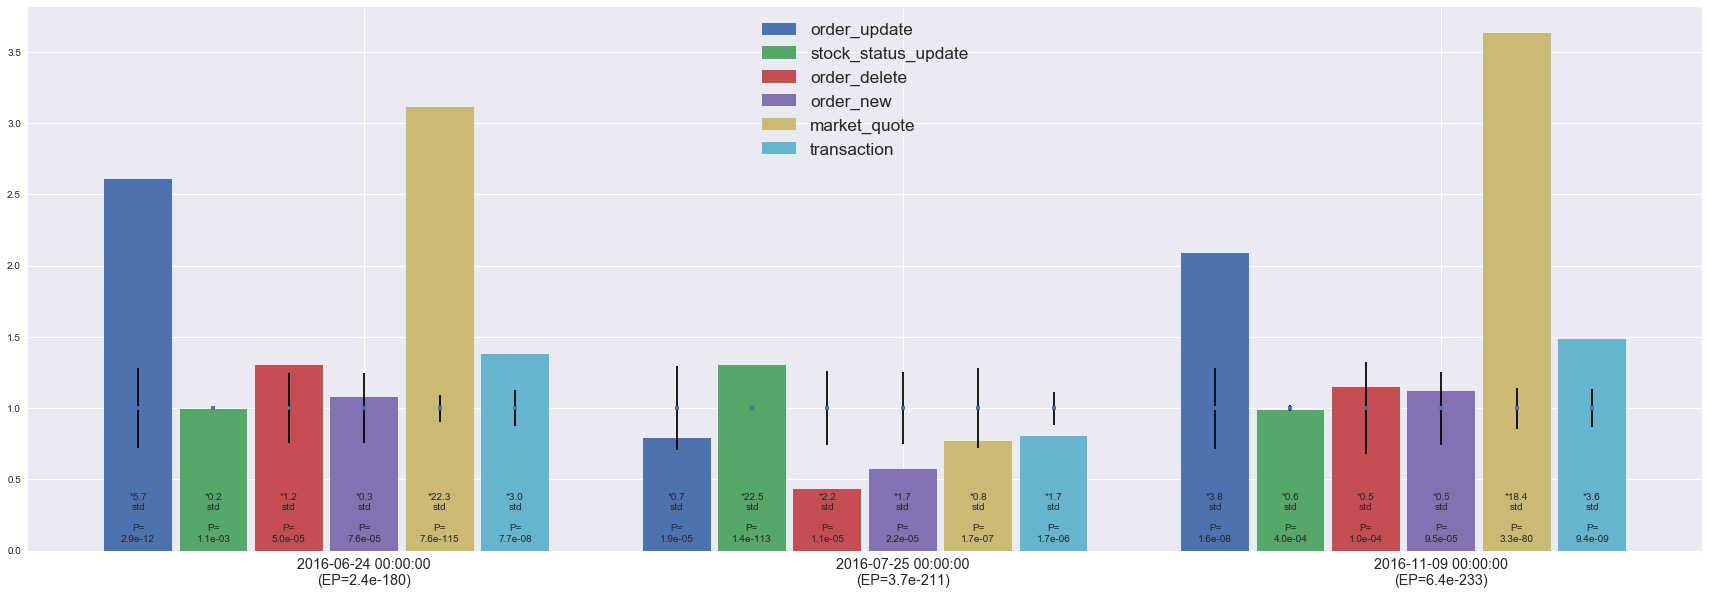

In [307]:
from random import random
ind = np.arange(outliers.shape[0])
width = 0.14


fig, ax = plt.subplots(figsize=(30,10))

colors = [(1,1,1)] + [(random(),random(),random()) for i in range(255)]

## Plot Bar Chart
for i, col in enumerate(outliers.columns):
    bar_left = ind+(i*width)
    bar_height=outliers[col]/outlier_rolling_mean[col]
    bar_width=width-width/10
    #color=colors[int(random() * 255)-1]
    color=f'C{i}'
    
    ax.bar(bar_left, bar_height, bar_width, color=color)
    

## Plot sigma and univariate probability
y_axis = 0.05

for i, col in enumerate(outliers.columns): 
    for j, date in enumerate(outliers.index): 
        x_axis = j+(i*width)
        prob = str('{0:0.1e}'.format(outlier_metric_probability.loc[date, col]))
        sigma = str('{0:0.1f}'.format((abs(outliers[col]-outlier_rolling_mean[col]) / outlier_rolling_std[col])[date]))
        text = '*' + sigma + '\nstd\n\nP=\n' + prob
        ax.text(x_axis, y_axis, text, ha='center', va='bottom')
   
## Plot Error Bar
for i, col in enumerate(outliers.columns):
    plt.errorbar(ind+(i*width), outlier_rolling_mean[col]/outlier_rolling_mean[col], outlier_rolling_std[col]/outlier_rolling_mean[col], 
                 marker='s', linestyle='None', ecolor='k', ms=2, mew=2)
    
    
## Legend
ax.legend(outliers.columns, fontsize='xx-large', loc='upper center')

## Xticks and labels
date_with_event_prob = ['%s\n(EP=%.1e)' % (x, y) for (x, y) in zip(outliers.index, probabilities.loc[outliers.index].values)]

ax.set_xticks(ind+width*(outliers.shape[1]/2))
ax.set_xticklabels(date_with_event_prob, fontsize='x-large', rotation='horizontal');

### Visualize Msg Count, Rolling Mean and Std

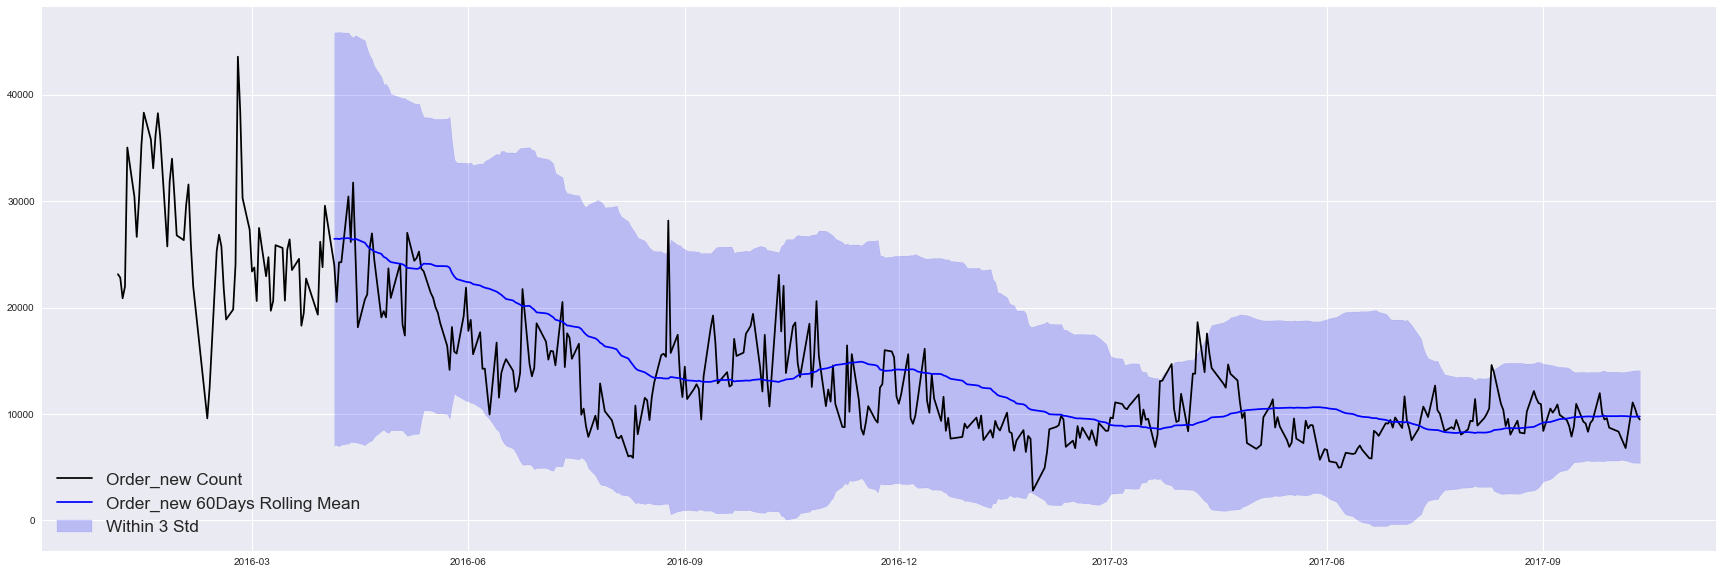

In [306]:
msg_type = 'order_new'
shade_std = 3 # The shade area is +/- 3 standard deviation

#--------------------
plt.figure(figsize = (30,10))
plt.plot(msg_count.index, msg_count[msg_type], 'k', label=msg_type.capitalize() + ' Count')

plt.plot(rolling_mean.index, rolling_mean[msg_type], 'b', label=msg_type.capitalize()+' '+str(rolling_window)+'Days Rolling Mean')
plt.fill_between(rolling_std.index, 
                 rolling_mean[msg_type]-shade_std*rolling_std[msg_type], 
                 rolling_mean[msg_type]+shade_std*rolling_std[msg_type], color='b', alpha=0.2, label='Within %d Std' % shade_std)
plt.legend(loc='lower left', fontsize='xx-large');

## Part III. Model Testing

### Tweak the feature weights

In [293]:
# Find the highest probability - a day metrics closest to the mean
best_date = probabilities.idxmax()
msg_count.loc[best_date]

,order_update,stock_status_update,order_delete,order_new,market_quote,transaction
date,,,,,,
2017-07-11,84044.0,45517.5,6799.0,9716.5,7272563.5,596783.0


**Below tests:**
- first tries to make 'transaction' more important - which making it more sensitive and drives down the probability - more likely to be considered an outlier. In fact scaling it up by x7 will trun to probability to 0 - absolute outlier
- then tries to make 'num_transactions' less important - which drives up the probability - less likely to be considered an outlier.

In [294]:
## Calculate the unskewed event probability
prob = multivariate_normal.pdf(msg_count_scaled.loc[best_date].squeeze(), 
                               mean=rolling_mean_scaled.loc[best_date].squeeze(), 
                               cov=rolling_cov_scaled.loc[best_date].squeeze())

print('Probability(Unskewed) = {:.8f}'.format(prob))


## Tweak the weight by making one of the feature much MORE important
test_weight = pd.DataFrame([msg_count_scaled.shape[1] * [1.0],], columns=msg_count_scaled.columns, index=['weight'])
test_weight['transaction'] = 6 

prob = multivariate_normal.pdf(msg_count_scaled.loc[best_date].squeeze() * test_weight, 
                               mean=rolling_mean_scaled.loc[best_date].squeeze(), 
                               cov=rolling_cov_scaled.loc[best_date].squeeze())

print('Probability(with sensitive feature) = {:.8f}'.format(prob))


## Tweak the weight by making one of the feature much LESS important
test_weight = pd.DataFrame([msg_count_scaled.shape[1] * [1.0],], columns=msg_count_scaled.columns, index=['weight'])
test_weight['transaction'] =  0.1

prob = multivariate_normal.pdf(msg_count_scaled.loc[best_date].squeeze() * test_weight, 
                               mean=rolling_mean_scaled.loc[best_date].squeeze(), 
                               cov=rolling_cov_scaled.loc[best_date].squeeze())

print('Probability(with non-sensitive feature) = {:.8f}'.format(prob))

Probability(Unskewed) = 0.03876507
Probability(with sensitive feature) = 0.00000009
Probability(with non-sensitive feature) = 0.07352864
